In [15]:
!pip install --upgrade install seaborn matplotlib pandas numpy scikit-learn optuna alembic importlib_resources mako tqdm

Looking in links: https://download.pytorch.org/whl/nightly/cu113/torch_nightly.htmL
  Using cached https://files.pythonhosted.org/packages/c0/f2/b12037765c40da46d7a48914dda220187a69d3a6a1ff102330c2e647f9a6/torch-1.10.1-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/10/5b/0479d7d845b5ba410ca702ffcd7f2cd95a14a4dfff1fde2637802b258b9b/seaborn-0.11.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/71/97/b93e7edcdf5f0321bef2c8404ca8e8401e7f1f869ba8ee986f71514ca1b3/matplotlib-3.5.1-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/b2/56/f886ed6f1777ffa9d54c6e80231b69db8a1f52dcc33f5967b06a105dcfe0/pandas-1.3.5-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/22/a3/3a5469ebaca59100e50b4300dd011eed943f2aad7c6a80a07966b985e2c6/numpy-1.21.5-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/9d/20/0ffe8665a44bce7616bd33d4368a198fecad3b226bcafa38c63ef0f62

ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\users\\itay\\documents\\github\\cuda-experiments\\venv\\lib\\site-packages\\~-rch\\lib\\asmjit.dll'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
import json
from src.models.gmf import GMF
from src.models.autorec import AutoRec
from src.models.autorec_v2 import AutoRecV2
from src.training import GMFTrainer, AutoRecTrainer
from src.datasets import make_dataloader, GMFRatingDataset, IAutoRecRatingDataset, UAutoRecRatingDataset, make_weighted_dataloader
from src.metrics import GMFEvaluator, IAutoRecEvaluator, UAutoRecEvaluator
from src.hyperparameter_optimization import hyperparameter_tune

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

In [3]:
ml_df = pd.read_csv('data/ml_1m_preprocessed.csv')
print(ml_df.shape)

am_df = pd.read_csv('data/am_preprocessed.csv')
print(am_df.shape)

In [4]:
n_users_ml = ml_df['user_id'].max() + 1
n_items_ml = ml_df['item_id'].max() + 1
print(n_users_ml, n_items_ml)

n_users_am = am_df['user_id'].max() + 1
n_items_am = am_df['item_id'].max() + 1
print(n_users_am, n_items_am)

In [5]:
train_test_seed = 123
train_val_seed = 666

train_val_df_ml, test_df_ml = train_test_split(ml_df, test_size=.1, random_state=train_test_seed)
train_df_ml, validation_df_ml = train_test_split(train_val_df_ml, test_size=.1, random_state=train_val_seed)

train_val_df_am, test_df_am = train_test_split(am_df, test_size=.1, random_state=train_test_seed)
train_df_am, validation_df_am = train_test_split(train_val_df_am, test_size=.1, random_state=train_val_seed)

## GMF

##### HP Optimization - MovieLens

In [77]:
gmf_ml_hyperparams, gmf_ml_trials_df = (
    hyperparameter_tune('GMF', {
        'embedding_dimensions': (int, (4, 32), False),
        'embeddings_init_std': (float, (.01, 1), True),
        'reg': (float, (1e-8, 1e-4), True)
    }, train_val_df_ml, lr=1e-3, n_trials=10, batch_size=128, patience=0, n_epochs=50, verbose=True))

print(gmf_ml_hyperparams)
with open('hyperparams/gmf_ml.json', 'w') as f:
    json.dump(gmf_ml_hyperparams, f, indent=4)

gmf_ml_trials_df.to_csv('hyperparams/gmf_ml_trials.csv', index=False)

[I 2022-01-31 21:25:50,255] A new study created in memory with name: no-name-ef3e2773-b2b3-4577-9087-427143a3d0f9
Validation: 100%|█████████████████████████████████████████| 1055/1055 [00:01<00:00, 627.55it/s, Loss=793, rmse=0.86689]
[I 2022-01-31 21:39:34,987] Trial 0 finished with value: 0.8668934300795358 and parameters: {'embedding_dimensions': 6, 'embeddings_init_std': 0.1629976230547335, 'reg': 6.591874519790134e-06}. Best is trial 0 with value: 0.8668934300795358.
Train epoch 17/50: 100%|██████████████████████████████| 5978/5978 [00:12<00:00, 472.75it/s, Loss=3.53e+3, rmse=0.76837]


Validation: 100%|█████████████████████████████████████████| 1055/1055 [00:01<00:00, 748.86it/s, Loss=864, rmse=0.90471]
[I 2022-01-31 21:51:31,712] Trial 1 finished with value: 0.9047094989067176 and parameters: {'embedding_dimensions': 13, 'embeddings_init_std': 0.2765111867675153, 'reg': 6.566933603013049e-05}. Best is trial 0 with value: 0.8668934300795358.


Validation: 100%|█████████████████████████████████████████| 1055/1055 [00:01<00:00, 768.86it/s, Loss=853, rmse=0.89927]
[I 2022-01-31 22:03:57,796] Trial 2 finished with value: 0.8992745508208936 and parameters: {'embedding_dimensions': 12, 'embeddings_init_std': 0.8657660724831594, 'reg': 7.983385813202092e-06}. Best is trial 0 with value: 0.8668934300795358.
Validation: 100%|█████████████████████████████████████████| 1055/1055 [00:01<00:00, 759.26it/s, Loss=804, rmse=0.87285]


Validation: 100%|█████████████████████████████████████████| 1055/1055 [00:01<00:00, 749.49it/s, Loss=807, rmse=0.87477]
[I 2022-01-31 22:16:44,599] Trial 3 finished with value: 0.8747689148928138 and parameters: {'embedding_dimensions': 7, 'embeddings_init_std': 0.1522156487673692, 'reg': 3.4936158005944782e-06}. Best is trial 0 with value: 0.8668934300795358.
Validation: 100%|█████████████████████████████████████████| 1055/1055 [00:01<00:00, 752.02it/s, Loss=958, rmse=0.95287]


Validation: 100%|████████████████████████████████████████| 1055/1055 [00:01<00:00, 798.44it/s, Loss=1e+3, rmse=0.97339]
[I 2022-01-31 22:29:06,931] Trial 4 finished with value: 0.973390397690276 and parameters: {'embedding_dimensions': 24, 'embeddings_init_std': 0.015379472483294432, 'reg': 2.278425370131219e-05}. Best is trial 0 with value: 0.8668934300795358.
Validation: 100%|███████████████████████████████████████████| 1055/1055 [00:01<00:00, 695.41it/s, Loss=877, rmse=0.912]
[I 2022-01-31 22:40:54,919] Trial 5 finished with value: 0.9120015928672385 and parameters: {'embedding_dimensions': 15, 'embeddings_init_std': 0.01723319486753755, 'reg': 2.5263113111657892e-06}. Best is trial 0 with value: 0.8668934300795358.


Validation: 100%|██████████████████████████████████████| 1055/1055 [00:01<00:00, 784.42it/s, Loss=1.02e+3, rmse=0.9827]
[I 2022-01-31 22:52:35,909] Trial 6 finished with value: 0.9826958003729804 and parameters: {'embedding_dimensions': 24, 'embeddings_init_std': 0.1516452876374851, 'reg': 5.204652927066414e-06}. Best is trial 0 with value: 0.8668934300795358.
Validation: 100%|█████████████████████████████████████████| 1055/1055 [00:01<00:00, 780.91it/s, Loss=873, rmse=0.90958]


Validation: 100%|█████████████████████████████████████████| 1055/1055 [00:01<00:00, 786.50it/s, Loss=941, rmse=0.94429]
[I 2022-01-31 23:04:26,001] Trial 7 finished with value: 0.9442876903541808 and parameters: {'embedding_dimensions': 19, 'embeddings_init_std': 0.09874715653368374, 'reg': 1.9549824506336195e-08}. Best is trial 0 with value: 0.8668934300795358.
Validation: 100%|█████████████████████████████████████████| 1055/1055 [00:01<00:00, 789.34it/s, Loss=967, rmse=0.95738]


Validation: 100%|██████████████████████████████████████| 1055/1055 [00:01<00:00, 806.06it/s, Loss=1.01e+3, rmse=0.9785]
[I 2022-01-31 23:16:14,763] Trial 8 finished with value: 0.9784975241913102 and parameters: {'embedding_dimensions': 24, 'embeddings_init_std': 0.058390566451582485, 'reg': 6.482127810292836e-05}. Best is trial 0 with value: 0.8668934300795358.
Validation: 100%|█████████████████████████████████████| 1055/1055 [00:01<00:00, 808.56it/s, Loss=1.12e+3, rmse=1.02937]
[I 2022-01-31 23:28:08,672] Trial 9 finished with value: 1.0293734717732943 and parameters: {'embedding_dimensions': 31, 'embeddings_init_std': 0.3269752688597204, 'reg': 4.3288415337813417e-07}. Best is trial 0 with value: 0.8668934300795358.


{'embedding_dimensions': 6, 'embeddings_init_std': 0.1629976230547335, 'reg': 6.591874519790134e-06}


#### Final training - MovieLens

training with HP:  {'embedding_dimensions': 6, 'embeddings_init_std': 0.1629976230547335, 'reg': 6.591874519790134e-06}


Validation: 100%|███████████████████████████████████████████| 782/782 [00:00<00:00, 803.02it/s, Loss=586, rmse=0.86597]


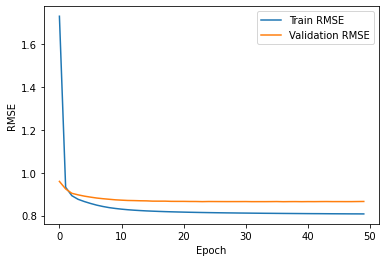

100%|██████████████████████████████████████████████████████████████████████████████| 782/782 [00:00<00:00, 2090.03it/s]


{'RMSE': 0.8659055969567322,
 'MRR@5': 0.6376410772153337,
 'MRR@10': 0.6414545519850607,
 'nDCG@5': 0.9286387381733398,
 'nDCG@10': 0.9443788588944488}

In [78]:
gmf_ml_hyperparams = json.load(open('hyperparams/gmf_ml.json'))
print('training with HP: ', gmf_ml_hyperparams)

ml_train_dataloader = make_dataloader(train_val_df_ml, GMFRatingDataset, n_users_ml, n_items_ml,  batch_size=128, **gmf_ml_hyperparams)
ml_test_dataloader = make_dataloader(test_df_ml, GMFRatingDataset, n_users_ml, n_items_ml, batch_size=128, **gmf_ml_hyperparams)

gmf = GMF(n_users_ml, n_items_ml, **gmf_ml_hyperparams).to(device)
gmf_trainer = GMFTrainer(ml_train_dataloader, ml_test_dataloader, gmf, device,n_epochs=50, patience=0, verbose=True, **gmf_ml_hyperparams)
thist, vhist, thist_rme, vhist_rme = gmf_trainer.train()

plt.plot(thist_rme, label='Train RMSE')
plt.plot(vhist_rme, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

torch.save(gmf, 'trained_models/gmf_ml.pt')

gmf_ml_eval = GMFEvaluator().evaluate(gmf, ml_test_dataloader, device, cutoff=5)
gmf_ml_eval

##### HP Optimization - Amazon Music

In [79]:
gmf_am_hyperparams, gmf_am_trials_df = (
    hyperparameter_tune('GMF', {
        'embedding_dimensions': (int, (4, 32), False),
        'embeddings_init_std': (float, (.01, 1), True),
        'reg': (float, (1e-8, 1e-4), True)
    }, train_val_df_am, lr=1e-3, n_trials=10, batch_size=128, patience=0, n_epochs=50, verbose=True))

print(gmf_am_hyperparams)
with open('hyperparams/gmf_am.json', 'w') as f:
    json.dump(gmf_am_hyperparams, f, indent=4)

gmf_am_trials_df.to_csv('hyperparams/gmf_am_trials.csv', index=False)

[I 2022-01-31 23:41:59,504] A new study created in memory with name: no-name-d8a71ace-3cb8-4eed-8070-90aa031758f8
Validation: 100%|██████████████████████████████████████████| 180/180 [00:00<00:00, 832.31it/s, Loss=71.2, rmse=0.62911]
[I 2022-01-31 23:43:51,216] Trial 0 finished with value: 0.6291098195435219 and parameters: {'embedding_dimensions': 21, 'embeddings_init_std': 0.02367035338145824, 'reg': 1.9365453068169994e-07}. Best is trial 0 with value: 0.6291098195435219.
Train epoch 17/50: 100%|██████████████████████████████████| 1015/1015 [00:01<00:00, 522.87it/s, Loss=427, rmse=0.64852]


Validation: 100%|███████████████████████████████████████████| 180/180 [00:00<00:00, 873.79it/s, Loss=168, rmse=0.96609]
[I 2022-01-31 23:45:39,141] Trial 1 finished with value: 0.966094522236128 and parameters: {'embedding_dimensions': 5, 'embeddings_init_std': 0.8891882331513616, 'reg': 4.859229404667923e-06}. Best is trial 0 with value: 0.6291098195435219.


Validation: 100%|███████████████████████████████████████████| 180/180 [00:00<00:00, 861.51it/s, Loss=112, rmse=0.78878]
[I 2022-01-31 23:47:32,642] Trial 2 finished with value: 0.7887796975812333 and parameters: {'embedding_dimensions': 30, 'embeddings_init_std': 0.1896927519609652, 'reg': 2.5706740801561064e-07}. Best is trial 0 with value: 0.6291098195435219.
Validation: 100%|███████████████████████████████████████████| 180/180 [00:00<00:00, 851.68it/s, Loss=208, rmse=1.07428]


Validation: 100%|███████████████████████████████████████████| 180/180 [00:00<00:00, 858.12it/s, Loss=145, rmse=0.89772]
[I 2022-01-31 23:49:21,882] Trial 3 finished with value: 0.897720048240298 and parameters: {'embedding_dimensions': 18, 'embeddings_init_std': 0.38977579999459583, 'reg': 9.940791130546293e-05}. Best is trial 0 with value: 0.6291098195435219.
Validation: 100%|███████████████████████████████████████████| 180/180 [00:00<00:00, 830.08it/s, Loss=74.8, rmse=0.6445]


Validation: 100%|██████████████████████████████████████████| 180/180 [00:00<00:00, 839.09it/s, Loss=65.5, rmse=0.60305]
[I 2022-01-31 23:51:11,649] Trial 4 finished with value: 0.6030523618792878 and parameters: {'embedding_dimensions': 22, 'embeddings_init_std': 0.01345838401151454, 'reg': 1.9167823395911252e-06}. Best is trial 4 with value: 0.6030523618792878.
Validation: 100%|███████████████████████████████████████████| 180/180 [00:00<00:00, 831.22it/s, Loss=146, rmse=0.90005]
[I 2022-01-31 23:53:01,896] Trial 5 finished with value: 0.9000526033238144 and parameters: {'embedding_dimensions': 5, 'embeddings_init_std': 0.12817379409456175, 'reg': 4.790007544933434e-08}. Best is trial 4 with value: 0.6030523618792878.


Validation: 100%|████████████████████████████████████████████| 180/180 [00:00<00:00, 836.53it/s, Loss=73, rmse=0.63675]
[I 2022-01-31 23:55:00,087] Trial 6 finished with value: 0.6367517949651972 and parameters: {'embedding_dimensions': 32, 'embeddings_init_std': 0.03947056702567982, 'reg': 5.5423603702412104e-05}. Best is trial 4 with value: 0.6030523618792878.
Validation: 100%|█████████████████████████████████████████████| 180/180 [00:00<00:00, 843.03it/s, Loss=278, rmse=1.243]


Validation: 100%|███████████████████████████████████████████| 180/180 [00:00<00:00, 837.21it/s, Loss=124, rmse=0.82973]
[I 2022-01-31 23:56:57,712] Trial 7 finished with value: 0.8297281699899883 and parameters: {'embedding_dimensions': 31, 'embeddings_init_std': 0.3006207271019471, 'reg': 6.008090160237325e-07}. Best is trial 4 with value: 0.6030523618792878.
Validation: 100%|██████████████████████████████████████████| 180/180 [00:00<00:00, 829.51it/s, Loss=86.4, rmse=0.69299]


Validation: 100%|██████████████████████████████████████████| 180/180 [00:00<00:00, 861.12it/s, Loss=73.8, rmse=0.64015]
[I 2022-01-31 23:58:49,909] Trial 8 finished with value: 0.640149664794411 and parameters: {'embedding_dimensions': 18, 'embeddings_init_std': 0.015421174833122879, 'reg': 3.346951761972002e-08}. Best is trial 4 with value: 0.6030523618792878.
Validation: 100%|██████████████████████████████████████████| 180/180 [00:00<00:00, 865.14it/s, Loss=96.8, rmse=0.73349]
[I 2022-02-01 00:00:38,485] Trial 9 finished with value: 0.7334892551965208 and parameters: {'embedding_dimensions': 16, 'embeddings_init_std': 0.059377214865613356, 'reg': 1.719859177558537e-05}. Best is trial 4 with value: 0.6030523618792878.


{'embedding_dimensions': 22, 'embeddings_init_std': 0.01345838401151454, 'reg': 1.9167823395911252e-06}


#### Final training - Amazon Music

training with HP:  {'embedding_dimensions': 22, 'embeddings_init_std': 0.01345838401151454, 'reg': 1.9167823395911252e-06}


Validation: 100%|██████████████████████████████████████████| 133/133 [00:00<00:00, 849.05it/s, Loss=44.8, rmse=0.58035]


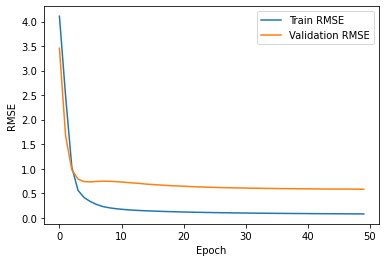

100%|██████████████████████████████████████████████████████████████████████████████| 133/133 [00:00<00:00, 2300.00it/s]


{'RMSE': 0.580412259352308,
 'MRR@5': 0.8378847309092193,
 'MRR@10': 0.8379023993780698,
 'nDCG@5': 0.997092386302109,
 'nDCG@10': 0.9973565177316761}

In [80]:
gmf_am_hyperparams = json.load(open('hyperparams/gmf_am.json'))
print('training with HP: ', gmf_am_hyperparams)

am_train_dataloader = make_dataloader(train_val_df_am, GMFRatingDataset, n_users_am, n_items_am,  batch_size=128, **gmf_am_hyperparams)
am_test_dataloader = make_dataloader(test_df_am, GMFRatingDataset, n_users_am, n_items_am, batch_size=128, **gmf_am_hyperparams)

gmf = GMF(n_users_am, n_items_am, **gmf_am_hyperparams).to(device)
gmf_trainer = GMFTrainer(am_train_dataloader, am_test_dataloader, gmf, device,n_epochs=50, patience=0, verbose=True, **gmf_am_hyperparams)
thist, vhist, thist_rme, vhist_rme = gmf_trainer.train()

plt.plot(thist_rme, label='Train RMSE')
plt.plot(vhist_rme, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

torch.save(gmf, 'trained_models/gmf_am.pt')

gmf_am_eval = GMFEvaluator().evaluate(gmf, am_test_dataloader, device, cutoff=5)
gmf_am_eval

## UAutoRec

##### HP Optimization - MovieLens

In [103]:
uautorec_ml_hyperparams, uautorec_ml_trials_df = (
    hyperparameter_tune('UAutoRec', {
    'hidden_size': (int, (128, 1024), False),
    'reg_lambda': (float, (1e-4, 1e3), True),
     }, train_val_df_ml, lr=1e-3, n_trials=10, batch_size=128, patience=0, n_epochs=200, verbose=True,
       enqueue_trials=[dict(reg_lambda=1e-1,hidden_size=512)]))

print(uautorec_ml_hyperparams)
with open('hyperparams/uautorec_ml.json', 'w') as f:
    json.dump(uautorec_ml_hyperparams, f, indent=4)

uautorec_ml_trials_df.to_csv('hyperparams/uautorec_ml_trials.csv', index=False)

[I 2022-02-01 20:58:30,104] A new study created in memory with name: no-name-1626a965-37c7-4300-8434-c16d60d7d08f
C:\Users\Itay\Documents\GitHub\cuda-experiments\src\hyperparameter_optimization.py:85: ExperimentalWarning: enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.
  study.enqueue_trial(trial)
C:\Users\Itay\anaconda3\lib\site-packages\optuna\study\study.py:857: ExperimentalWarning: create_trial is experimental (supported from v2.0.0). The interface can change in the future.
  create_trial(state=TrialState.WAITING, system_attrs={"fixed_params": params})
C:\Users\Itay\anaconda3\lib\site-packages\optuna\study\study.py:856: ExperimentalWarning: add_trial is experimental (supported from v2.0.0). The interface can change in the future.
  self.add_trial(
Train epoch 65/200: 100%|██████████████████████████████████| 48/48 [00:00<00:00, 59.80it/s, Loss=5.23e+4, rmse=0.17482]


Train epoch 133/200: 100%|█████████████████████████████████| 48/48 [00:00<00:00, 60.11it/s, Loss=3.67e+4, rmse=0.12251]


Validation: 100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 73.79it/s, Loss=1.3e+5, rmse=0.88438]
[I 2022-02-01 21:03:25,114] Trial 0 finished with value: 0.8843777622532476 and parameters: {'hidden_size': 512, 'reg_lambda': 0.1}. Best is trial 0 with value: 0.8843777622532476.


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 78.36it/s, Loss=1.17e+5, rmse=0.91221]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 80.63it/s, Loss=1.16e+5, rmse=0.91113]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 86.25it/s, Loss=1.14e+5, rmse=0.90447]
[I 2022-02-01 21:07:49,899] Trial 1 finished with value: 0.904474918560596 and parameters: {'hidden_size': 606, 'reg_lambda': 0.008508372894690914}. Best is trial 0 with value: 0.8843777622532476.
Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 87.43it/s, Loss=4.08e+5, rmse=1.21401]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 85.83it/s, Loss=2.26e+5, rmse=1.02308]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 75.83it/s, Loss=2.44e+5, rmse=0.99213]


Validation: 100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 83.40it/s, Loss=2.5e+5, rmse=0.98301]
[I 2022-02-01 21:11:54,491] Trial 2 finished with value: 0.9830107469247744 and parameters: {'hidden_size': 227, 'reg_lambda': 11.077321844531424}. Best is trial 0 with value: 0.8843777622532476.
Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 85.79it/s, Loss=1.79e+5, rmse=1.11715]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 82.12it/s, Loss=1.57e+5, rmse=0.92167]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 83.84it/s, Loss=1.54e+5, rmse=0.91413]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 86.48it/s, Loss=1.51e+5, rmse=0.90776]
[I 2022-02-01 21:16:05,047] Trial 3 finished with value: 0.9077641065231699 and parameters: {'hidden_size': 407, 'reg_lambda': 0.16474112145126835}. Best is trial 0 with value: 0.8843777622532476.
Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 80.80it/s, Loss=1.51e+5, rmse=1.05291]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 82.06it/s, Loss=1.26e+5, rmse=0.94014]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 79.46it/s, Loss=1.26e+5, rmse=0.94105]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 86.09it/s, Loss=1.25e+5, rmse=0.93727]
[I 2022-02-01 21:20:17,417] Trial 4 finished with value: 0.9372667452925348 and parameters: {'hidden_size': 477, 'reg_lambda': 0.014461117183213959}. Best is trial 0 with value: 0.8843777622532476.
Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 80.67it/s, Loss=1.27e+5, rmse=0.96779]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 89.71it/s, Loss=1.11e+5, rmse=0.90323]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 80.73it/s, Loss=1.12e+5, rmse=0.90403]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 91.69it/s, Loss=1.12e+5, rmse=0.90799]
[I 2022-02-01 21:24:38,294] Trial 5 finished with value: 0.907993553620214 and parameters: {'hidden_size': 716, 'reg_lambda': 0.0008354360234336683}. Best is trial 0 with value: 0.8843777622532476.
Validation: 100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 92.17it/s, Loss=1.51e+5, rmse=1.0552]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 92.84it/s, Loss=1.28e+5, rmse=0.97131]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 90.30it/s, Loss=1.38e+5, rmse=1.00737]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 91.68it/s, Loss=1.41e+5, rmse=1.01929]
[I 2022-02-01 21:28:26,944] Trial 6 finished with value: 1.0192865843019636 and parameters: {'hidden_size': 370, 'reg_lambda': 0.0001813514356465006}. Best is trial 0 with value: 0.8843777622532476.
Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 92.22it/s, Loss=2.27e+5, rmse=1.14112]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 92.65it/s, Loss=2.15e+5, rmse=1.00439]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 92.21it/s, Loss=2.46e+5, rmse=0.98342]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 94.39it/s, Loss=2.56e+5, rmse=0.97593]
[I 2022-02-01 21:32:08,631] Trial 7 finished with value: 0.9759337906406124 and parameters: {'hidden_size': 177, 'reg_lambda': 5.636188612294026}. Best is trial 0 with value: 0.8843777622532476.
Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 93.76it/s, Loss=1.23e+5, rmse=0.90474]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 86.18it/s, Loss=1.12e+5, rmse=0.86348]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 79.40it/s, Loss=1.07e+5, rmse=0.84124]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 85.26it/s, Loss=1.06e+5, rmse=0.84107]
[I 2022-02-01 21:36:24,396] Trial 8 finished with value: 0.8410740003334617 and parameters: {'hidden_size': 967, 'reg_lambda': 0.04174713034841211}. Best is trial 8 with value: 0.8410740003334617.
Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 85.03it/s, Loss=2.67e+5, rmse=1.03958]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 91.95it/s, Loss=2.92e+5, rmse=0.98557]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 91.77it/s, Loss=2.95e+5, rmse=0.98025]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 84.13it/s, Loss=2.95e+5, rmse=0.97422]
[I 2022-02-01 21:40:25,758] Trial 9 finished with value: 0.9742199081999322 and parameters: {'hidden_size': 414, 'reg_lambda': 9.69378648424191}. Best is trial 8 with value: 0.8410740003334617.


{'hidden_size': 967, 'reg_lambda': 0.04174713034841211}


#### Final training - MovieLens

training with HP:  {'hidden_size': 967, 'reg_lambda': 0.04174713034841211}


Validation: 100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 81.42it/s, Loss=8.7e+4, rmse=0.84831]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 80.73it/s, Loss=8.15e+4, rmse=0.83239]


Validation: 100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 80.23it/s, Loss=7.9e+4, rmse=0.82104]


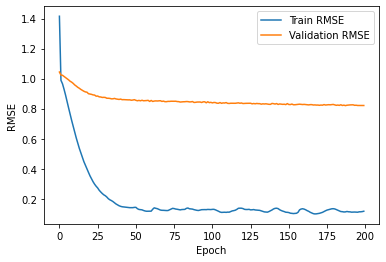

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 40.78it/s]


{'RMSE': 0.8216905772822014,
 'MRR@5': 0.7534193764666444,
 'MRR@10': 0.7543588270038153,
 'nDCG@5': 0.9691573400950945,
 'nDCG@10': 0.972835421409584}

In [104]:
uautorec_ml_hyperparams = json.load(open('hyperparams/uautorec_ml.json'))
print('training with HP: ', uautorec_ml_hyperparams)

ml_train_dataloader = make_dataloader(train_val_df_ml, UAutoRecRatingDataset, n_users_ml, n_items_ml,  batch_size=128, **uautorec_ml_hyperparams)
ml_test_dataloader = make_dataloader(test_df_ml, UAutoRecRatingDataset, n_users_ml, n_items_ml, batch_size=128, **uautorec_ml_hyperparams)

autorec = AutoRec(n_items_ml, **uautorec_ml_hyperparams).to(device)
autorec_trainer = AutoRecTrainer(ml_train_dataloader, ml_test_dataloader, autorec, device,n_epochs=200, patience=0, verbose=True, **uautorec_ml_hyperparams)
thist, vhist, thist_rme, vhist_rme = autorec_trainer.train()

plt.plot(thist_rme, label='Train RMSE')
plt.plot(vhist_rme, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

torch.save(autorec, 'trained_models/uautorec_ml.pt')

uautorec_ml_eval = UAutoRecEvaluator().evaluate(autorec, ml_test_dataloader, device, cutoff=5)
uautorec_ml_eval

##### HP Optimization - Amazon Music

In [105]:
uautorec_am_hyperparams, uautorec_am_trials_df = (
    hyperparameter_tune('UAutoRec', {
    'hidden_size': (int, (128, 1024), False),
    'reg_lambda': (float, (1e-4, 1e3), True),
     }, train_val_df_am, lr=1e-3, n_trials=10, batch_size=128, patience=0, n_epochs=200, verbose=True,
       enqueue_trials=[dict(reg_lambda=1e-1,hidden_size=512)]))

print(uautorec_am_hyperparams)
with open('hyperparams/uautorec_am.json', 'w') as f:
    json.dump(uautorec_am_hyperparams, f, indent=4)

uautorec_am_trials_df.to_csv('hyperparams/uautorec_am_trials.csv', index=False)

[I 2022-02-01 21:45:12,190] A new study created in memory with name: no-name-f0e90d95-cd40-43eb-9a8b-e81ebfeaed36
C:\Users\Itay\Documents\GitHub\cuda-experiments\src\hyperparameter_optimization.py:85: ExperimentalWarning: enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.
  study.enqueue_trial(trial)
C:\Users\Itay\anaconda3\lib\site-packages\optuna\study\study.py:857: ExperimentalWarning: create_trial is experimental (supported from v2.0.0). The interface can change in the future.
  create_trial(state=TrialState.WAITING, system_attrs={"fixed_params": params})
C:\Users\Itay\anaconda3\lib\site-packages\optuna\study\study.py:856: ExperimentalWarning: add_trial is experimental (supported from v2.0.0). The interface can change in the future.
  self.add_trial(
Train epoch 65/200: 100%|████████████████████████████████| 130/130 [00:05<00:00, 24.41it/s, Loss=6.76e+4, rmse=0.54082]


Train epoch 133/200: 100%|████████████████████████████████| 130/130 [00:05<00:00, 23.94it/s, Loss=5.62e+4, rmse=0.4663]


Validation: 100%|████████████████████████████████████████| 130/130 [00:04<00:00, 28.52it/s, Loss=4.29e+4, rmse=0.76442]
[I 2022-02-01 22:18:47,004] Trial 0 finished with value: 0.7644211116109424 and parameters: {'hidden_size': 512, 'reg_lambda': 0.1}. Best is trial 0 with value: 0.7644211116109424.


Validation: 100%|████████████████████████████████████████| 130/130 [00:04<00:00, 27.91it/s, Loss=3.65e+5, rmse=2.25553]


Validation: 100%|█████████████████████████████████████████| 130/130 [00:04<00:00, 28.18it/s, Loss=1.3e+5, rmse=1.31808]


Validation: 100%|████████████████████████████████████████| 130/130 [00:04<00:00, 27.83it/s, Loss=2.57e+4, rmse=0.90143]
[I 2022-02-01 22:51:43,643] Trial 1 finished with value: 0.9014258717138935 and parameters: {'hidden_size': 491, 'reg_lambda': 404.4452645474703}. Best is trial 0 with value: 0.7644211116109424.
Validation: 100%|████████████████████████████████████████| 130/130 [00:04<00:00, 28.23it/s, Loss=3.12e+4, rmse=1.17319]


Validation: 100%|████████████████████████████████████████| 130/130 [00:04<00:00, 29.65it/s, Loss=1.46e+4, rmse=0.79267]


Validation: 100%|████████████████████████████████████████| 130/130 [00:03<00:00, 32.87it/s, Loss=1.47e+4, rmse=0.79244]


Validation: 100%|████████████████████████████████████████| 130/130 [00:04<00:00, 29.79it/s, Loss=1.46e+4, rmse=0.79121]
[I 2022-02-01 23:21:45,992] Trial 2 finished with value: 0.7912080953379032 and parameters: {'hidden_size': 255, 'reg_lambda': 0.00028704466685386203}. Best is trial 0 with value: 0.7644211116109424.
Validation: 100%|████████████████████████████████████████| 130/130 [00:04<00:00, 30.64it/s, Loss=8.96e+4, rmse=0.83994]


Validation: 100%|████████████████████████████████████████| 130/130 [00:04<00:00, 28.28it/s, Loss=5.76e+4, rmse=0.85999]


Validation: 100%|████████████████████████████████████████| 130/130 [00:04<00:00, 29.30it/s, Loss=5.16e+4, rmse=0.82684]


Validation: 100%|████████████████████████████████████████| 130/130 [00:04<00:00, 29.91it/s, Loss=4.87e+4, rmse=0.81905]
[I 2022-02-01 23:52:26,364] Trial 3 finished with value: 0.8190493478285283 and parameters: {'hidden_size': 316, 'reg_lambda': 0.3674633427345667}. Best is trial 0 with value: 0.7644211116109424.
Validation: 100%|████████████████████████████████████████| 130/130 [00:04<00:00, 29.71it/s, Loss=5.01e+4, rmse=0.93231]


Validation: 100%|████████████████████████████████████████| 130/130 [00:04<00:00, 27.50it/s, Loss=4.43e+4, rmse=0.77302]


Validation: 100%|████████████████████████████████████████| 130/130 [00:04<00:00, 29.18it/s, Loss=4.31e+4, rmse=0.75845]


Validation: 100%|████████████████████████████████████████| 130/130 [00:04<00:00, 28.59it/s, Loss=4.19e+4, rmse=0.75139]
[I 2022-02-02 00:25:03,024] Trial 4 finished with value: 0.7513923209239739 and parameters: {'hidden_size': 195, 'reg_lambda': 0.09873789771443141}. Best is trial 4 with value: 0.7513923209239739.
Validation: 100%|████████████████████████████████████████| 130/130 [00:05<00:00, 25.28it/s, Loss=1.53e+4, rmse=0.82123]


Validation: 100%|█████████████████████████████████████████| 130/130 [00:04<00:00, 30.35it/s, Loss=1.57e+4, rmse=0.8226]


Validation: 100%|████████████████████████████████████████| 130/130 [00:04<00:00, 29.70it/s, Loss=1.48e+4, rmse=0.79757]


Validation: 100%|████████████████████████████████████████| 130/130 [00:04<00:00, 28.79it/s, Loss=1.46e+4, rmse=0.79204]
[I 2022-02-02 01:02:00,055] Trial 5 finished with value: 0.7920445167022836 and parameters: {'hidden_size': 570, 'reg_lambda': 0.00013639695432723535}. Best is trial 4 with value: 0.7513923209239739.
Validation: 100%|████████████████████████████████████████| 130/130 [00:04<00:00, 27.32it/s, Loss=1.35e+4, rmse=0.76021]


Validation: 100%|████████████████████████████████████████| 130/130 [00:04<00:00, 28.50it/s, Loss=1.48e+4, rmse=0.78412]


Validation: 100%|████████████████████████████████████████| 130/130 [00:04<00:00, 26.60it/s, Loss=1.46e+4, rmse=0.78017]


Validation: 100%|████████████████████████████████████████| 130/130 [00:04<00:00, 27.59it/s, Loss=1.45e+4, rmse=0.77831]
[I 2022-02-02 01:34:51,686] Trial 6 finished with value: 0.7783102744170998 and parameters: {'hidden_size': 320, 'reg_lambda': 0.0005096255492584687}. Best is trial 4 with value: 0.7513923209239739.
Validation: 100%|████████████████████████████████████████| 130/130 [00:04<00:00, 28.17it/s, Loss=7.75e+4, rmse=0.93429]


Validation: 100%|████████████████████████████████████████| 130/130 [00:04<00:00, 28.21it/s, Loss=6.14e+4, rmse=0.87896]


Validation: 100%|█████████████████████████████████████████| 130/130 [00:04<00:00, 28.56it/s, Loss=5.4e+4, rmse=0.84674]


Validation: 100%|████████████████████████████████████████| 130/130 [00:04<00:00, 28.56it/s, Loss=5.18e+4, rmse=0.84886]
[I 2022-02-02 02:07:23,559] Trial 7 finished with value: 0.8488631161623089 and parameters: {'hidden_size': 402, 'reg_lambda': 0.5453751755237876}. Best is trial 4 with value: 0.7513923209239739.
Validation: 100%|████████████████████████████████████████| 130/130 [00:04<00:00, 27.05it/s, Loss=1.74e+4, rmse=0.80037]


Validation: 100%|████████████████████████████████████████| 130/130 [00:04<00:00, 28.48it/s, Loss=1.74e+4, rmse=0.77723]


Validation: 100%|████████████████████████████████████████| 130/130 [00:04<00:00, 27.94it/s, Loss=1.61e+4, rmse=0.76283]


Validation: 100%|████████████████████████████████████████| 130/130 [00:04<00:00, 27.80it/s, Loss=1.56e+4, rmse=0.75076]
[I 2022-02-02 02:40:48,799] Trial 8 finished with value: 0.7507622081198633 and parameters: {'hidden_size': 468, 'reg_lambda': 0.002885606822088767}. Best is trial 8 with value: 0.7507622081198633.
Validation: 100%|████████████████████████████████████████| 130/130 [00:04<00:00, 28.45it/s, Loss=5.03e+4, rmse=0.80653]


Validation: 100%|███████████████████████████████████████████| 130/130 [00:04<00:00, 29.16it/s, Loss=5e+4, rmse=0.80253]


Validation: 100%|████████████████████████████████████████| 130/130 [00:04<00:00, 26.93it/s, Loss=4.72e+4, rmse=0.77199]


Validation: 100%|████████████████████████████████████████| 130/130 [00:04<00:00, 27.60it/s, Loss=4.67e+4, rmse=0.78029]
[I 2022-02-02 03:12:50,708] Trial 9 finished with value: 0.7802933750339598 and parameters: {'hidden_size': 232, 'reg_lambda': 0.17033129382565132}. Best is trial 8 with value: 0.7507622081198633.


{'hidden_size': 468, 'reg_lambda': 0.002885606822088767}


#### Final training - Amazon Music

Validation: 100%|█████████████████████████████████████████| 130/130 [00:04<00:00, 26.47it/s, Loss=1.4e+4, rmse=0.79195]


Validation: 100%|████████████████████████████████████████| 130/130 [00:04<00:00, 28.09it/s, Loss=1.41e+4, rmse=0.78045]


Validation: 100%|████████████████████████████████████████| 130/130 [00:04<00:00, 27.93it/s, Loss=1.39e+4, rmse=0.77522]


Validation: 100%|█████████████████████████████████████████| 130/130 [00:04<00:00, 27.96it/s, Loss=1.35e+4, rmse=0.7763]


Validation: 100%|█████████████████████████████████████████| 130/130 [00:04<00:00, 28.18it/s, Loss=1.3e+4, rmse=0.76839]


Validation: 100%|████████████████████████████████████████| 130/130 [00:04<00:00, 28.61it/s, Loss=1.28e+4, rmse=0.76151]


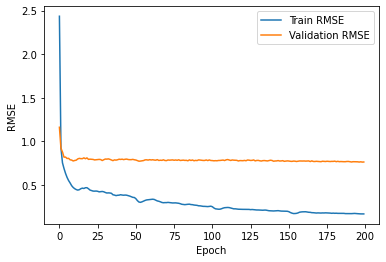

100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:08<00:00, 16.24it/s]


{'RMSE': 0.756502392462996,
 'MRR@5': 0.8379130004593798,
 'MRR@10': 0.8379262518110177,
 'nDCG@5': 0.9974158297761423,
 'nDCG@10': 0.9976254812831239}

In [6]:
uautorec_am_hyperparams = json.load(open('hyperparams/uautorec_am.json'))
print('training with HP: ', uautorec_am_hyperparams)

am_train_dataloader = make_dataloader(train_val_df_am, UAutoRecRatingDataset, n_users_am, n_items_am,  batch_size=128, **uautorec_am_hyperparams)
am_test_dataloader = make_dataloader(test_df_am, UAutoRecRatingDataset, n_users_am, n_items_am, batch_size=128, **uautorec_am_hyperparams)

autorec = AutoRec(n_items_am, **uautorec_am_hyperparams).to(device)
autorec_trainer = AutoRecTrainer(am_train_dataloader, am_test_dataloader, autorec, device,n_epochs=200, patience=0, verbose=True, **uautorec_am_hyperparams)
thist, vhist, thist_rme, vhist_rme = autorec_trainer.train()

plt.plot(thist_rme, label='Train RMSE')
plt.plot(vhist_rme, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

torch.save(autorec, 'trained_models/uautorec_am.pt')

uautorec_am_eval = UAutoRecEvaluator().evaluate(autorec, am_test_dataloader, device, cutoff=5)
uautorec_am_eval

## IAutoRec

##### HP Optimization - MovieLens

In [107]:
iautorec_ml_hyperparams, iautorec_ml_trials_df = (
    hyperparameter_tune('IAutoRec', {
    'hidden_size': (int, (8, 512), False),
    'reg_lambda': (float, (1e-4, 1e2), True),
     }, train_val_df_ml, lr=1e-3, n_trials=10, batch_size=128, patience=0, n_epochs=200, verbose=True,
       enqueue_trials=[dict(reg_lambda=1e-1,hidden_size=16)]))

print(iautorec_ml_hyperparams)
with open('hyperparams/iautorec_ml.json', 'w') as f:
    json.dump(iautorec_ml_hyperparams, f, indent=4)

iautorec_ml_trials_df.to_csv('hyperparams/iautorec_trials_ml.csv', index=False)

[I 2022-02-02 03:46:56,284] A new study created in memory with name: no-name-f6d9ecde-afe9-4470-bfaf-ff1c22025b57
C:\Users\Itay\Documents\GitHub\cuda-experiments\src\hyperparameter_optimization.py:85: ExperimentalWarning: enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.
  study.enqueue_trial(trial)
C:\Users\Itay\anaconda3\lib\site-packages\optuna\study\study.py:857: ExperimentalWarning: create_trial is experimental (supported from v2.0.0). The interface can change in the future.
  create_trial(state=TrialState.WAITING, system_attrs={"fixed_params": params})
C:\Users\Itay\anaconda3\lib\site-packages\optuna\study\study.py:856: ExperimentalWarning: add_trial is experimental (supported from v2.0.0). The interface can change in the future.
  self.add_trial(
Train epoch 65/200: 100%|██████████████████████████████████| 29/29 [00:00<00:00, 98.14it/s, Loss=6.07e+5, rmse=0.88436]


Train epoch 133/200: 100%|█████████████████████████████████| 29/29 [00:00<00:00, 97.62it/s, Loss=5.71e+5, rmse=0.85611]


Validation: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 102.83it/s, Loss=1.39e+5, rmse=0.96814]
[I 2022-02-02 03:48:49,029] Trial 0 finished with value: 0.9681406831200293 and parameters: {'hidden_size': 16, 'reg_lambda': 0.1}. Best is trial 0 with value: 0.9681406831200293.


Validation: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 107.81it/s, Loss=4.19e+5, rmse=1.10158]


Validation: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 109.13it/s, Loss=3.72e+5, rmse=1.08524]


Validation: 100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 110.89it/s, Loss=3.5e+5, rmse=1.08844]
[I 2022-02-02 03:50:54,301] Trial 1 finished with value: 1.0884377992720555 and parameters: {'hidden_size': 453, 'reg_lambda': 82.58029982550497}. Best is trial 0 with value: 0.9681406831200293.
Validation: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 113.28it/s, Loss=4.72e+5, rmse=1.13133]


Validation: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 105.44it/s, Loss=3.92e+5, rmse=1.01459]


Validation: 100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 109.02it/s, Loss=3.5e+5, rmse=1.00443]


Validation: 100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 98.97it/s, Loss=3.17e+5, rmse=0.99483]
[I 2022-02-02 03:52:48,815] Trial 2 finished with value: 0.9948296873401824 and parameters: {'hidden_size': 65, 'reg_lambda': 14.045475560647873}. Best is trial 0 with value: 0.9681406831200293.
Validation: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 104.68it/s, Loss=1.49e+5, rmse=1.03675]


Validation: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 105.64it/s, Loss=1.49e+5, rmse=0.99589]


Validation: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 103.57it/s, Loss=1.67e+5, rmse=1.02545]


Validation: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 105.44it/s, Loss=1.76e+5, rmse=1.04937]
[I 2022-02-02 03:54:51,225] Trial 3 finished with value: 1.0493651501924914 and parameters: {'hidden_size': 195, 'reg_lambda': 0.11773040673464934}. Best is trial 0 with value: 0.9681406831200293.
Validation: 100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 101.38it/s, Loss=1.4e+5, rmse=1.01458]


Validation: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 103.75it/s, Loss=1.36e+5, rmse=0.98894]


Validation: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 109.42it/s, Loss=1.47e+5, rmse=1.02133]


Validation: 100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 98.29it/s, Loss=1.57e+5, rmse=1.05271]
[I 2022-02-02 03:56:53,883] Trial 4 finished with value: 1.052708306562395 and parameters: {'hidden_size': 183, 'reg_lambda': 0.02243992041557595}. Best is trial 0 with value: 0.9681406831200293.
Validation: 100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 95.54it/s, Loss=1.37e+5, rmse=1.00931]


Validation: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 106.03it/s, Loss=1.35e+5, rmse=1.00031]


Validation: 100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 103.57it/s, Loss=1.45e+5, rmse=1.0352]


Validation: 100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 99.99it/s, Loss=1.52e+5, rmse=1.06017]
[I 2022-02-02 03:59:02,941] Trial 5 finished with value: 1.060168885410249 and parameters: {'hidden_size': 260, 'reg_lambda': 0.00018478077201398234}. Best is trial 0 with value: 0.9681406831200293.
Validation: 100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 97.63it/s, Loss=1.34e+5, rmse=0.99787]


Validation: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 100.86it/s, Loss=1.35e+5, rmse=0.99938]


Validation: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 100.17it/s, Loss=1.44e+5, rmse=1.03281]


Validation: 100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 93.69it/s, Loss=1.51e+5, rmse=1.05822]
[I 2022-02-02 04:01:09,919] Trial 6 finished with value: 1.0582241641711512 and parameters: {'hidden_size': 233, 'reg_lambda': 0.0002916495869424809}. Best is trial 0 with value: 0.9681406831200293.
Validation: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 105.26it/s, Loss=1.39e+5, rmse=1.01499]


Validation: 100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 94.15it/s, Loss=1.36e+5, rmse=1.00142]


Validation: 100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 97.79it/s, Loss=1.39e+5, rmse=1.01384]


Validation: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 104.88it/s, Loss=1.41e+5, rmse=1.01767]
[I 2022-02-02 04:03:22,963] Trial 7 finished with value: 1.0176684991913107 and parameters: {'hidden_size': 459, 'reg_lambda': 0.0012783098668806205}. Best is trial 0 with value: 0.9681406831200293.
Validation: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 115.76it/s, Loss=1.29e+5, rmse=0.97903]


Validation: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 115.54it/s, Loss=1.24e+5, rmse=0.96096]


Validation: 100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 107.77it/s, Loss=1.31e+5, rmse=0.9842]


Validation: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 113.05it/s, Loss=1.35e+5, rmse=0.99994]
[I 2022-02-02 04:05:18,488] Trial 8 finished with value: 0.9999406638710706 and parameters: {'hidden_size': 67, 'reg_lambda': 0.00041633967743913013}. Best is trial 0 with value: 0.9681406831200293.
Validation: 100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 97.32it/s, Loss=1.29e+5, rmse=0.97722]


Validation: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 112.40it/s, Loss=1.29e+5, rmse=0.97683]


Validation: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 108.60it/s, Loss=1.39e+5, rmse=1.01377]


Validation: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 105.26it/s, Loss=1.44e+5, rmse=1.03019]
[I 2022-02-02 04:07:14,970] Trial 9 finished with value: 1.0301947501142428 and parameters: {'hidden_size': 104, 'reg_lambda': 0.0001491663515264016}. Best is trial 0 with value: 0.9681406831200293.


{'hidden_size': 16, 'reg_lambda': 0.1}


##### Final Training -  MovieLens

training with HP:  {'hidden_size': 16, 'reg_lambda': 0.1}


Validation: 100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 106.62it/s, Loss=1.1e+5, rmse=1.00653]


Validation: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 100.00it/s, Loss=1.07e+5, rmse=0.99034]


Validation: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 111.54it/s, Loss=1.09e+5, rmse=0.99325]


Validation: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 108.59it/s, Loss=1.08e+5, rmse=0.98922]


Validation: 100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 102.65it/s, Loss=1.1e+5, rmse=0.99195]


Validation: 100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 115.08it/s, Loss=1.11e+5, rmse=0.99284]


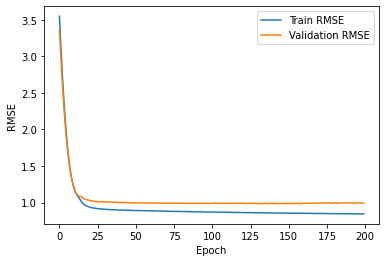

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 42.83it/s]


{'RMSE': 0.9927281432205904,
 'MRR@5': 0.5662587998659091,
 'MRR@10': 0.572391035976355,
 'nDCG@5': 0.9022123022913984,
 'nDCG@10': 0.9236118942305}

In [7]:
iautorec_ml_hyperparams = json.load(open('hyperparams/iautorec_ml.json'))
print('training with HP: ', iautorec_ml_hyperparams)

train_dataloader = make_dataloader(train_val_df_ml, IAutoRecRatingDataset, n_users_ml, n_items_ml,  batch_size=128, **iautorec_ml_hyperparams)
test_dataloader = make_dataloader(test_df_ml, IAutoRecRatingDataset, n_users_ml, n_items_ml, batch_size=128, **iautorec_ml_hyperparams)

autorec = AutoRec(n_users_ml, **iautorec_ml_hyperparams).to(device)
autorec_trainer = AutoRecTrainer(train_dataloader, test_dataloader, autorec, device, n_epochs=200, patience=0, verbose=True, **iautorec_ml_hyperparams)
thist, vhist, thist_rme, vhist_rme = autorec_trainer.train()

plt.plot(thist_rme, label='Train RMSE')
plt.plot(vhist_rme, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

torch.save(autorec, 'trained_models/iautorec_ml.pt')

iautorec_ml_eval = IAutoRecEvaluator().evaluate(autorec, test_dataloader, device, cutoff=5)
iautorec_ml_eval

##### HP Optimization - Amazon Music

In [109]:
iautorec_am_hyperparams, iautorec_am_trials_df = (
    hyperparameter_tune('IAutoRec', {
    'hidden_size': (int, (8, 512), False),
    'reg_lambda': (float, (1e-4, 1e2), True),
     }, train_val_df_am, lr=1e-3, n_trials=10, batch_size=128, patience=0, n_epochs=200, verbose=True,
       enqueue_trials=[dict(reg_lambda=1e-1,hidden_size=16)]))

print(iautorec_am_hyperparams)
with open('hyperparams/iautorec_am.json', 'w') as f:
    json.dump(iautorec_am_hyperparams, f, indent=4)
    
iautorec_am_trials_df.to_csv('hyperparams/iautorec_trials_am.csv', index=False)

[I 2022-02-02 04:09:19,016] A new study created in memory with name: no-name-136c4c40-4c20-4845-a903-eeefe90258e2
C:\Users\Itay\Documents\GitHub\cuda-experiments\src\hyperparameter_optimization.py:85: ExperimentalWarning: enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.
  study.enqueue_trial(trial)
C:\Users\Itay\anaconda3\lib\site-packages\optuna\study\study.py:857: ExperimentalWarning: create_trial is experimental (supported from v2.0.0). The interface can change in the future.
  create_trial(state=TrialState.WAITING, system_attrs={"fixed_params": params})
C:\Users\Itay\anaconda3\lib\site-packages\optuna\study\study.py:856: ExperimentalWarning: add_trial is experimental (supported from v2.0.0). The interface can change in the future.
  self.add_trial(
Train epoch 65/200: 100%|██████████████████████████████████| 93/93 [00:02<00:00, 43.12it/s, Loss=1.13e+5, rmse=0.54303]


Train epoch 133/200: 100%|█████████████████████████████████| 93/93 [00:02<00:00, 43.89it/s, Loss=8.13e+4, rmse=0.51979]


Validation: 100%|█████████████████████████████████████████████| 93/93 [00:01<00:00, 46.55it/s, Loss=4e+4, rmse=0.60192]
[I 2022-02-02 04:23:07,428] Trial 0 finished with value: 0.60191734637089 and parameters: {'hidden_size': 16, 'reg_lambda': 0.1}. Best is trial 0 with value: 0.60191734637089.


Validation: 100%|███████████████████████████████████████████| 93/93 [00:02<00:00, 44.30it/s, Loss=3.82e+4, rmse=0.7308]


Validation: 100%|██████████████████████████████████████████| 93/93 [00:02<00:00, 45.35it/s, Loss=3.54e+4, rmse=0.68283]


Validation: 100%|███████████████████████████████████████████| 93/93 [00:01<00:00, 47.10it/s, Loss=3.33e+4, rmse=0.6505]
[I 2022-02-02 04:38:45,271] Trial 1 finished with value: 0.6505011952606463 and parameters: {'hidden_size': 370, 'reg_lambda': 0.11600667068196623}. Best is trial 0 with value: 0.60191734637089.
Validation: 100%|██████████████████████████████████████████| 93/93 [00:01<00:00, 47.50it/s, Loss=1.62e+5, rmse=1.33614]


Validation: 100%|██████████████████████████████████████████| 93/93 [00:01<00:00, 47.19it/s, Loss=5.68e+4, rmse=0.72432]


Validation: 100%|██████████████████████████████████████████| 93/93 [00:01<00:00, 47.09it/s, Loss=4.89e+4, rmse=0.71501]


Validation: 100%|██████████████████████████████████████████| 93/93 [00:01<00:00, 48.69it/s, Loss=4.53e+4, rmse=0.69781]
[I 2022-02-02 04:53:16,971] Trial 2 finished with value: 0.6978122942764536 and parameters: {'hidden_size': 231, 'reg_lambda': 0.5217564653527829}. Best is trial 0 with value: 0.60191734637089.
Validation: 100%|██████████████████████████████████████████| 93/93 [00:01<00:00, 48.33it/s, Loss=7.12e+4, rmse=0.82878]


Validation: 100%|███████████████████████████████████████████| 93/93 [00:01<00:00, 48.91it/s, Loss=4.52e+4, rmse=0.7386]


Validation: 100%|██████████████████████████████████████████| 93/93 [00:01<00:00, 48.92it/s, Loss=4.17e+4, rmse=0.69599]


Validation: 100%|██████████████████████████████████████████| 93/93 [00:01<00:00, 49.60it/s, Loss=3.94e+4, rmse=0.67748]
[I 2022-02-02 05:07:40,350] Trial 3 finished with value: 0.6774847981268927 and parameters: {'hidden_size': 352, 'reg_lambda': 0.1983106813646501}. Best is trial 0 with value: 0.60191734637089.
Validation: 100%|███████████████████████████████████████████| 93/93 [00:01<00:00, 49.11it/s, Loss=7.1e+4, rmse=0.73812]


Validation: 100%|██████████████████████████████████████████| 93/93 [00:01<00:00, 47.03it/s, Loss=5.16e+4, rmse=0.76531]


Validation: 100%|███████████████████████████████████████████| 93/93 [00:02<00:00, 44.13it/s, Loss=4.49e+4, rmse=0.6936]


Validation: 100%|██████████████████████████████████████████| 93/93 [00:01<00:00, 46.86it/s, Loss=4.29e+4, rmse=0.68574]
[I 2022-02-02 05:23:22,676] Trial 4 finished with value: 0.6857403369821035 and parameters: {'hidden_size': 497, 'reg_lambda': 0.27714976500535154}. Best is trial 0 with value: 0.60191734637089.
Validation: 100%|██████████████████████████████████████████| 93/93 [00:01<00:00, 47.34it/s, Loss=4.08e+4, rmse=0.71767]


Validation: 100%|██████████████████████████████████████████| 93/93 [00:02<00:00, 44.62it/s, Loss=3.51e+4, rmse=0.72025]


Validation: 100%|██████████████████████████████████████████| 93/93 [00:02<00:00, 44.09it/s, Loss=3.24e+4, rmse=0.66953]


Validation: 100%|███████████████████████████████████████████| 93/93 [00:02<00:00, 46.07it/s, Loss=3.08e+4, rmse=0.6494]
[I 2022-02-02 05:39:01,897] Trial 5 finished with value: 0.6493985878877676 and parameters: {'hidden_size': 368, 'reg_lambda': 0.09478562552180268}. Best is trial 0 with value: 0.60191734637089.
Validation: 100%|███████████████████████████████████████████| 93/93 [00:02<00:00, 45.82it/s, Loss=7.8e+4, rmse=0.96451]


Validation: 100%|██████████████████████████████████████████| 93/93 [00:02<00:00, 45.09it/s, Loss=4.81e+4, rmse=0.65088]


Validation: 100%|██████████████████████████████████████████| 93/93 [00:01<00:00, 47.26it/s, Loss=4.26e+4, rmse=0.63054]


Validation: 100%|██████████████████████████████████████████| 93/93 [00:02<00:00, 46.21it/s, Loss=4.05e+4, rmse=0.63255]
[I 2022-02-02 05:53:14,087] Trial 6 finished with value: 0.6325460826692316 and parameters: {'hidden_size': 155, 'reg_lambda': 0.2943829379738293}. Best is trial 0 with value: 0.60191734637089.
Validation: 100%|███████████████████████████████████████████| 93/93 [00:02<00:00, 44.86it/s, Loss=2.02e+4, rmse=0.7153]


Validation: 100%|███████████████████████████████████████████| 93/93 [00:01<00:00, 47.49it/s, Loss=1.9e+4, rmse=0.69589]


Validation: 100%|██████████████████████████████████████████| 93/93 [00:01<00:00, 49.15it/s, Loss=1.63e+4, rmse=0.63865]


Validation: 100%|██████████████████████████████████████████| 93/93 [00:01<00:00, 49.14it/s, Loss=1.59e+4, rmse=0.62911]
[I 2022-02-02 06:08:21,314] Trial 7 finished with value: 0.629112367961621 and parameters: {'hidden_size': 383, 'reg_lambda': 0.016690930890088614}. Best is trial 0 with value: 0.60191734637089.
Validation: 100%|██████████████████████████████████████████| 93/93 [00:01<00:00, 49.81it/s, Loss=5.13e+5, rmse=3.84521]


Validation: 100%|██████████████████████████████████████████| 93/93 [00:01<00:00, 52.15it/s, Loss=2.01e+5, rmse=2.53751]


Validation: 100%|██████████████████████████████████████████| 93/93 [00:01<00:00, 48.51it/s, Loss=7.31e+4, rmse=1.62683]


Validation: 100%|██████████████████████████████████████████| 93/93 [00:01<00:00, 48.95it/s, Loss=3.95e+4, rmse=1.22903]
[I 2022-02-02 06:21:00,283] Trial 8 finished with value: 1.2290335326400377 and parameters: {'hidden_size': 13, 'reg_lambda': 22.62321562223295}. Best is trial 0 with value: 0.60191734637089.
Validation: 100%|███████████████████████████████████████████| 93/93 [00:01<00:00, 47.52it/s, Loss=5.57e+5, rmse=1.7799]


Validation: 100%|██████████████████████████████████████████| 93/93 [00:01<00:00, 47.23it/s, Loss=2.86e+5, rmse=1.39244]


Validation: 100%|██████████████████████████████████████████| 93/93 [00:02<00:00, 45.57it/s, Loss=1.64e+5, rmse=1.15428]


Validation: 100%|██████████████████████████████████████████| 93/93 [00:02<00:00, 44.09it/s, Loss=1.18e+5, rmse=1.06539]
[I 2022-02-02 06:36:37,689] Trial 9 finished with value: 1.065389744074045 and parameters: {'hidden_size': 458, 'reg_lambda': 24.719875550776205}. Best is trial 0 with value: 0.60191734637089.


{'hidden_size': 16, 'reg_lambda': 0.1}


##### Final Training -  Amazon Music

training with HP:  {'hidden_size': 16, 'reg_lambda': 0.1}


Validation: 100%|██████████████████████████████████████████| 93/93 [00:01<00:00, 47.76it/s, Loss=1.05e+5, rmse=0.87438]


Validation: 100%|██████████████████████████████████████████| 93/93 [00:01<00:00, 48.51it/s, Loss=8.62e+4, rmse=0.64495]


Validation: 100%|██████████████████████████████████████████| 93/93 [00:01<00:00, 47.61it/s, Loss=6.92e+4, rmse=0.59803]


Validation: 100%|██████████████████████████████████████████| 93/93 [00:01<00:00, 48.06it/s, Loss=5.61e+4, rmse=0.59273]


Validation: 100%|███████████████████████████████████████████| 93/93 [00:01<00:00, 49.95it/s, Loss=4.6e+4, rmse=0.58613]


Validation: 100%|██████████████████████████████████████████| 93/93 [00:01<00:00, 50.73it/s, Loss=3.92e+4, rmse=0.58516]


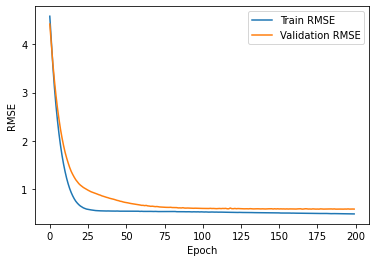

100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:05<00:00, 17.63it/s]


{'RMSE': 0.5854881584424756,
 'MRR@5': 0.8308208770627935,
 'MRR@10': 0.8309069898145481,
 'nDCG@5': 0.995897327720598,
 'nDCG@10': 0.9962836874344124}

In [8]:
iautorec_am_hyperparams = json.load(open('hyperparams/iautorec_am.json'))
print('training with HP: ', iautorec_am_hyperparams)

train_dataloader = make_dataloader(train_val_df_am, IAutoRecRatingDataset, n_users_am, n_items_am,  batch_size=128, **iautorec_am_hyperparams)
test_dataloader = make_dataloader(test_df_am, IAutoRecRatingDataset, n_users_am, n_items_am, batch_size=128, **iautorec_am_hyperparams)

autorec = AutoRec(n_users_am, **iautorec_am_hyperparams).to(device)
autorec_trainer = AutoRecTrainer(train_dataloader, test_dataloader, autorec, device, n_epochs=200, patience=0, verbose=True, **iautorec_am_hyperparams)
thist, vhist, thist_rme, vhist_rme = autorec_trainer.train()

plt.plot(thist_rme, label='Train RMSE')
plt.plot(vhist_rme, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

torch.save(autorec, 'trained_models/iautorec_am.pt')
iautorec_am_eval = IAutoRecEvaluator().evaluate(autorec, test_dataloader, device, cutoff=5)
iautorec_am_eval

### Noisy UAutoRec (AutoRecV2)

##### HP Optimization - MovieLens

In [111]:
uautorec_v2_ml_hyperparams, uautorec_v2_ml_trials_df = (
    hyperparameter_tune('ImprovedAutoRec', {
    'hidden_size': (int, (512, 1024), False),
    'reg_lambda': (float, (1e-4, 1e2), True),
    'latent_noise_factor': (float, (0, 1), False),
    'input_noise_factor': (float, (0, 1), False)
     }, train_val_df_ml, lr=1e-3, n_trials=10, batch_size=128, patience=0, n_epochs=200, verbose=True,
       enqueue_trials=[dict(reg_lambda=0.1,hidden_size=935, input_noise_factor=0.1, latent_noise_factor=0)]))

print(uautorec_v2_ml_hyperparams)
with open('hyperparams/uautorec_v2_ml.json', 'w') as f:
    json.dump(uautorec_v2_ml_hyperparams, f, indent=4)

uautorec_v2_ml_trials_df.to_csv('hyperparams/uautorec_v2_ml_trials.csv', index=False)


[I 2022-02-02 06:50:43,042] A new study created in memory with name: no-name-802fc172-7475-4277-a4ca-b6355bf10102
C:\Users\Itay\Documents\GitHub\cuda-experiments\src\hyperparameter_optimization.py:85: ExperimentalWarning: enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.
  study.enqueue_trial(trial)
C:\Users\Itay\anaconda3\lib\site-packages\optuna\study\study.py:857: ExperimentalWarning: create_trial is experimental (supported from v2.0.0). The interface can change in the future.
  create_trial(state=TrialState.WAITING, system_attrs={"fixed_params": params})
C:\Users\Itay\anaconda3\lib\site-packages\optuna\study\study.py:856: ExperimentalWarning: add_trial is experimental (supported from v2.0.0). The interface can change in the future.
  self.add_trial(
Train epoch 65/200: 100%|██████████████████████████████████| 48/48 [00:00<00:00, 60.60it/s, Loss=4.21e+4, rmse=0.15015]


Train epoch 133/200: 100%|███████████████████████████████████| 48/48 [00:00<00:00, 60.48it/s, Loss=3.61e+4, rmse=0.141]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 79.86it/s, Loss=1.12e+5, rmse=0.82437]
[I 2022-02-02 06:55:26,063] Trial 0 finished with value: 0.8243702309361818 and parameters: {'hidden_size': 935, 'reg_lambda': 0.1, 'latent_noise_factor': 0, 'input_noise_factor': 0.1}. Best is trial 0 with value: 0.8243702309361818.


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 76.87it/s, Loss=3.63e+5, rmse=1.04821]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 78.88it/s, Loss=3.31e+5, rmse=1.01385]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 80.71it/s, Loss=3.16e+5, rmse=1.01634]
[I 2022-02-02 07:00:09,555] Trial 1 finished with value: 1.0163383955544931 and parameters: {'hidden_size': 993, 'reg_lambda': 51.013517791508, 'latent_noise_factor': 0.896526452524195, 'input_noise_factor': 0.9956121102019657}. Best is trial 0 with value: 0.8243702309361818.
Train epoch 3/200: 100%|███████████████████████████████████| 48/48 [00:00<00:00, 60.92it/s, Loss=1.16e+6, rmse=1.02242]


Train epoch 71/200: 100%|██████████████████████████████████| 48/48 [00:00<00:00, 60.87it/s, Loss=5.15e+5, rmse=0.65276]


Train epoch 139/200: 100%|███████████████████████████████████| 48/48 [00:00<00:00, 61.10it/s, Loss=5.02e+5, rmse=0.638]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 80.26it/s, Loss=3.09e+5, rmse=0.93638]
[I 2022-02-02 07:04:49,825] Trial 2 finished with value: 0.9363830707837759 and parameters: {'hidden_size': 968, 'reg_lambda': 3.5993377345451667, 'latent_noise_factor': 0.3669189302717588, 'input_noise_factor': 0.3310515374067088}. Best is trial 0 with value: 0.8243702309361818.
Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 80.67it/s, Loss=1.74e+5, rmse=0.99565]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 79.73it/s, Loss=1.53e+5, rmse=0.86368]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 79.70it/s, Loss=1.54e+5, rmse=0.86171]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 80.46it/s, Loss=1.53e+5, rmse=0.85776]
[I 2022-02-02 07:09:32,067] Trial 3 finished with value: 0.8577550792410286 and parameters: {'hidden_size': 1023, 'reg_lambda': 0.2566135609935291, 'latent_noise_factor': 0.24028832685207346, 'input_noise_factor': 0.648762161406216}. Best is trial 0 with value: 0.8243702309361818.
Train epoch 8/200: 100%|███████████████████████████████████| 48/48 [00:00<00:00, 60.60it/s, Loss=9.31e+5, rmse=1.10312]


Train epoch 76/200: 100%|██████████████████████████████████| 48/48 [00:00<00:00, 59.88it/s, Loss=5.48e+5, rmse=0.84675]


Train epoch 144/200: 100%|███████████████████████████████████| 48/48 [00:00<00:00, 60.56it/s, Loss=5.2e+5, rmse=0.8255]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 81.90it/s, Loss=1.17e+5, rmse=0.92944]
[I 2022-02-02 07:14:12,209] Trial 4 finished with value: 0.9294361561458588 and parameters: {'hidden_size': 968, 'reg_lambda': 0.0005548968820290758, 'latent_noise_factor': 0.8417350156595117, 'input_noise_factor': 0.9158342707046131}. Best is trial 0 with value: 0.8243702309361818.
Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 80.87it/s, Loss=1.33e+5, rmse=0.99201]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 78.55it/s, Loss=1.09e+5, rmse=0.89541]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 81.63it/s, Loss=1.11e+5, rmse=0.90432]


Validation: 100%|█████████████████████████████████████████████| 48/48 [00:00<00:00, 86.02it/s, Loss=1.1e+5, rmse=0.903]
[I 2022-02-02 07:18:43,286] Trial 5 finished with value: 0.9030013364936524 and parameters: {'hidden_size': 755, 'reg_lambda': 0.0001465194360995415, 'latent_noise_factor': 0.3809011915502384, 'input_noise_factor': 0.7583125922307665}. Best is trial 0 with value: 0.8243702309361818.
Train epoch 13/200: 100%|██████████████████████████████████| 48/48 [00:00<00:00, 62.25it/s, Loss=5.45e+5, rmse=0.84142]


Train epoch 81/200: 100%|██████████████████████████████████| 48/48 [00:00<00:00, 66.06it/s, Loss=1.64e+5, rmse=0.45467]


Train epoch 149/200: 100%|█████████████████████████████████| 48/48 [00:00<00:00, 68.22it/s, Loss=1.44e+5, rmse=0.42444]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 83.69it/s, Loss=1.17e+5, rmse=0.89757]
[I 2022-02-02 07:23:00,334] Trial 6 finished with value: 0.8975662768740729 and parameters: {'hidden_size': 615, 'reg_lambda': 0.02126853535609515, 'latent_noise_factor': 0.12056636567581636, 'input_noise_factor': 0.6548337291792588}. Best is trial 0 with value: 0.8243702309361818.
Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 84.63it/s, Loss=2.25e+5, rmse=1.00137]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 80.67it/s, Loss=2.24e+5, rmse=0.97313]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 78.87it/s, Loss=2.24e+5, rmse=0.96473]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 78.27it/s, Loss=2.24e+5, rmse=0.96858]
[I 2022-02-02 07:27:36,474] Trial 7 finished with value: 0.9685775253363458 and parameters: {'hidden_size': 940, 'reg_lambda': 1.1863605661460774, 'latent_noise_factor': 0.966799692638674, 'input_noise_factor': 0.15226079400255677}. Best is trial 0 with value: 0.8243702309361818.
Train epoch 18/200: 100%|██████████████████████████████████| 48/48 [00:00<00:00, 59.66it/s, Loss=6.81e+5, rmse=0.94334]


Train epoch 86/200: 100%|██████████████████████████████████| 48/48 [00:00<00:00, 60.64it/s, Loss=5.14e+5, rmse=0.82084]


Train epoch 154/200: 100%|█████████████████████████████████| 48/48 [00:00<00:00, 59.99it/s, Loss=4.82e+5, rmse=0.79399]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 80.00it/s, Loss=1.15e+5, rmse=0.92128]
[I 2022-02-02 07:32:21,511] Trial 8 finished with value: 0.9212766715380956 and parameters: {'hidden_size': 892, 'reg_lambda': 0.0002395088047422519, 'latent_noise_factor': 0.9181726243039072, 'input_noise_factor': 0.5697430596415589}. Best is trial 0 with value: 0.8243702309361818.
Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 79.47it/s, Loss=3.07e+5, rmse=0.96775]


Validation: 100%|████████████████████████████████████████████| 48/48 [00:00<00:00, 77.85it/s, Loss=3.31e+5, rmse=0.936]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 79.93it/s, Loss=3.32e+5, rmse=0.93915]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 84.05it/s, Loss=3.32e+5, rmse=0.93834]
[I 2022-02-02 07:37:05,415] Trial 9 finished with value: 0.9383372138202447 and parameters: {'hidden_size': 908, 'reg_lambda': 4.822224827294195, 'latent_noise_factor': 0.16541951857162152, 'input_noise_factor': 0.6990269196936081}. Best is trial 0 with value: 0.8243702309361818.


{'hidden_size': 935, 'reg_lambda': 0.1, 'latent_noise_factor': 0, 'input_noise_factor': 0.1}


##### Final Training - MovieLens

In [ ]:
uautorec_v2_ml_hyperparams = json.load(open('hyperparams/uautorec_v2_ml.json'))
print('training with HP: ', uautorec_v2_ml_hyperparams)

train_dataloader = make_dataloader(train_val_df_ml, UAutoRecRatingDataset, n_users_ml, n_items_ml,  batch_size=128, **uautorec_v2_ml_hyperparams)
test_dataloader = make_dataloader(test_df_ml, UAutoRecRatingDataset, n_users_ml, n_items_ml, batch_size=128, **uautorec_v2_ml_hyperparams)

autorec = AutoRecV2(n_items_ml, **uautorec_v2_ml_hyperparams).to(device)
autorec_trainer = AutoRecTrainer(train_dataloader, test_dataloader, autorec, device, n_epochs=200, patience=0, verbose=True, **uautorec_v2_ml_hyperparams)
thist, vhist, thist_rme, vhist_rme = autorec_trainer.train()

plt.plot(thist_rme, label='Train RMSE')
plt.plot(vhist_rme, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

torch.save(autorec, 'trained_models/uautorec_v2_ml.pt')
uautorec_v2_ml_eval = UAutoRecEvaluator().evaluate(autorec, test_dataloader, device, cutoff=5)
uautorec_v2_ml_eval

training with HP:  {'hidden_size': 935, 'reg_lambda': 0.1, 'latent_noise_factor': 0, 'input_noise_factor': 0.1}


Validation:  52%|█████████████████████▉                    | 25/48 [00:00<00:00, 76.49it/s, Loss=5.64e+4, rmse=0.87255]

##### HP Optimization - Amazon Music

In [ ]:
uautorec_v2_am_hyperparams, uautorec_v2_am_trials_df = (
    hyperparameter_tune('ImprovedAutoRec', {
    'hidden_size': (int, (512, 1024), False),
    'reg_lambda': (float, (1e-4, 1e2), True),
    'latent_noise_factor': (float, (0, 1), False),
    'input_noise_factor': (float, (0, 1), False)
     }, train_val_df_am, lr=1e-3, n_trials=10, batch_size=128, patience=0, n_epochs=200, verbose=True,
       enqueue_trials=[dict(reg_lambda=0.1,hidden_size=935, input_noise_factor=0.1, latent_noise_factor=0)]))

print(uautorec_v2_am_hyperparams)
with open('hyperparams/uautorec_v2_am.json', 'w') as f:
    json.dump(uautorec_v2_am_hyperparams, f, indent=4)

uautorec_v2_am_trials_df.to_csv('hyperparams/uautorec_v2_am_trials.csv', index=False)


##### Final Training - Amazon Music

In [ ]:
uautorec_v2_am_hyperparams = json.load(open('hyperparams/uautorec_v2_am.json'))
print('training with HP: ', uautorec_v2_am_hyperparams)

train_dataloader = make_dataloader(train_val_df_am, UAutoRecRatingDataset, n_users_am, n_items_am,  batch_size=128, **uautorec_v2_am_hyperparams)
test_dataloader = make_dataloader(test_df_am, UAutoRecRatingDataset, n_users_am, n_items_am, batch_size=128, **uautorec_v2_am_hyperparams)

autorec = AutoRecV2(n_items_am, **uautorec_v2_am_hyperparams).to(device)
autorec_trainer = AutoRecTrainer(train_dataloader, test_dataloader, autorec, device, n_epochs=200, patience=0, verbose=True, **uautorec_v2_am_hyperparams)
thist, vhist, thist_rme, vhist_rme = autorec_trainer.train()

plt.plot(thist_rme, label='Train RMSE')
plt.plot(vhist_rme, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

torch.save(autorec, 'trained_models/uautorec_v2_am.pt')
uautorec_v2_am_eval = UAutoRecEvaluator().evaluate(autorec, test_dataloader, device, cutoff=5)
uautorec_v2_am_eval

### Results

In [ ]:
metrics = []

for model_name, dataset_name, model_eval in zip(
    ['GMF', 'GMF', 'UAutoRec', 'UAutoRec', 'IAutoRec', 'IAutoRec', 'UAutoRec_V2', 'UAutoRec_V2'],
    ['MovieLens', 'Amazon Music', 'MovieLens', 'Amazon Music', 'MovieLens', 'Amazon Music', 'MovieLens', 'Amazon Music'],
    [gmf_ml_eval, gmf_am_eval, uautorec_ml_eval, uautorec_am_eval, iautorec_ml_eval, 
     iautorec_am_eval, uautorec_v2_ml_eval, uautorec_v2_am_eval]
):
    metrics.append(dict(model_eval, **{'model_name':model_name, 'dataset_name':dataset_name}))

metrics_df = pd.DataFrame(metrics)
metrics_df

In [ ]:
def barplot_w_values(data=None, **kwargs):
    sns.barplot(data=data, **kwargs)
    x_col = kwargs['x']
    y_col = kwargs['y']
    for i, category in enumerate(data[x_col].unique()):
        y = data[(data[x_col] == category)][y_col].values[0]
        plt.text(i, y, f'{y:.3f}',
                 verticalalignment='bottom', horizontalalignment='center')
    
flat_df = metrics_df.melt(id_vars=['model_name', 'dataset_name']).rename(columns={'variable':'metric'})
fg = sns.FacetGrid(data=flat_df, col='metric', row='dataset_name', height=4)
fg.map_dataframe(barplot_w_values, x='model_name', y='value', palette='muted')
plt.show()